# Laboratory of Computational Physics (mod. B) - Physics of Data, Unipd

### Exercise 1

#### **Authors:**
- Qiqi Zhang 2072838
- David Altamirano 2081255
- Stefano Meza 2070772
- Francisco Pasian 2078684


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping
import pandas as pd
#from keras.callbacks import EarlyStopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=3)


!mkdir DATA

A subdirectory or file DATA already exists.


### Define non-linear functions

In [2]:
def f(x,c=1):
    r=0
    if c==1:
        if x[0]>-25 and x[1]>-35 and x[0]+x[1] < 30:
            r=1
        if x[0]+x[1] > 50:
            r=1
    if c==2:
        if (np.sign(x[0]-0.2*x[1]))*np.cos(np.linalg.norm(x)/(1.5*np.pi))>0:
            r=1
    return r


def filename(s,TYPE=1):
    return "./DATA/"+s+"-for-DNN-"+str(TYPE)+".dat"

### Generate Data (distribution 1 and 2)

In [3]:
# number of data
N=4000
# size of each sample
L=2
# box size
B=100

<function matplotlib.pyplot.show(close=None, block=None)>

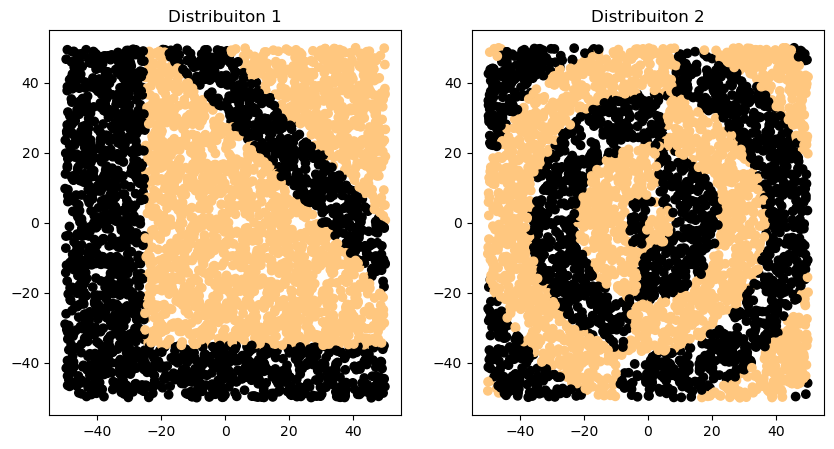

In [38]:
# random seed for reproducibility
np.random.seed(12345)

def generate_data(TYPE,N):
    x,y = (np.random.random((N,2))-0.5)*B, np.zeros(N)
    for i in range(N):
        # label data according to a nonlinear function "f"
        y[i] = f(x[i],TYPE)
    return x, y

x1, y1 = generate_data(1,N)
x2, y2 = generate_data(2,N)

fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axis[0].scatter(x1[:,0],x1[:,1],c=y1,cmap=cm.copper)
axis[0].set_title("Distribuiton 1")
axis[1].scatter(x2[:,0],x2[:,1],c=y2,cmap=cm.copper)
axis[1].set_title("Distribuiton 2")

plt.show

### Generate grid

In order to predict the labels with a random data, create a grid with the same dimensions of the training set 

In [5]:
#Generate a grid of lenght 50x50 (which is the size of the raw data)
dX = 2
X1 = np.arange(-50,50+dX, dX)

LG = len(X1)
grid = np.zeros((LG*LG,2))
#print(grid)
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1

#Normalize the grid for predicting the model        
grid_r=grid/50

#### Utils

In [6]:
def split_data_training_validation(data, labels,perc_train):
    #Number of total samples for distribution 2
    N=len(data)
    #Training set
    N_train = int(perc_train * N)

    #Split training and validation set 
    (data_train, label_train) = (data[0:N_train],labels[0:N_train])
    (data_valid, label_valid) = (data[N_train:],labels[N_train:])

    return(data_train, label_train, data_valid, label_valid)

#Rescale data
def Rescale(x):
    #return (x-x.mean())/np.sqrt(x.var())
    return x/50

# Problem 1

### 1.1 Define DNN for distribution 1

- Create a DNN model in which the parameters that can be optimized are: optimization algorithm, activation function, network weight initialization, dropout value and number of neurons.


In [7]:
# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

#Write it as a function so KerasClassifier function can work
#If not all hyperparameters will be changed, default values will be taken instead

def create_model(layers=3, optimizer="adam", activation="relu", dropout_rate=0.01, neurons = 20):
    #create model layer by layer
    model = Sequential()
    model.add(Dense(L,input_shape=(L,), activation='relu'))

    for i in range(1, layers):
        model.add(Dense(neurons, activation=activation))
        
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    # optimization method and cost function
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

### 1.2 Optimization for distribution 1

- Optimize the DNN previously defined to obtain the best accuracy. Using the x1,y1 dataset wich has 4000 samples in total from the distribution 1.

In [10]:
#Possible hyperparameters to be optimized (layers not working yet)
#batch_size = [10,25,50,75] #,100]#,100]
#epochs = [400] #[100,200,300,400]
optimizer = ["SGD", "Adagrad",  "adam",  "Nadam", "RMSprop", "Nesterov"]
activation = ["softmax",  "relu", "tanh", "sigmoid", "linear"]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#neurons = [15,20,25,30,35]
#layers=[2,3]
#init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero','glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

In [11]:
#create model 
model = KerasClassifier(model=create_model, 
                        batch_size=50,
                        epochs=400,
                        )

In [12]:
#Select which ones will be used in the GridSearchCV
#If batch_size or epochs is commented, then it must be written directly in the KerasClassifier
param_grid = dict(
                  #batch_size = batch_size,
                  #epochs=epochs,
                  optimizer=optimizer,
                  model__activation=activation #,
                  #model__dropout_rate= dropout_rate #it's set as 0.2 by default in create_model
                  #layers=layers
                  #model__neurons=neurons
                  #model__init_mode=init_mode
                   )

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3,verbose=2)
grid_result=grid.fit(x1,y1)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Epoch 1/400
80/80 [==============================] - 2s 4ms/step - loss: 1.1441 - accuracy: 0.5813
Epoch 2/400
80/80 [==============================] - 0s 4ms/step - loss: 0.6107 - accuracy: 0.6837
Epoch 3/400
80/80 [==============================] - 0s 4ms/step - loss: 0.5569 - accuracy: 0.7290
Epoch 4/400
80/80 [==============================] - 0s 4ms/step - loss: 0.5287 - accuracy: 0.7427
Epoch 5/400
80/80 [==============================] - 0s 4ms/step - loss: 0.5163 - accuracy: 0.7538
Epoch 6/400
80/80 [==============================] - 0s 4ms/step - loss: 0.4981 - accuracy: 0.7710
Epoch 7/400
80/80 [==============================] - 0s 4ms/step - loss: 0.4909 - accuracy: 0.7738
Epoch 8/400
80/80 [==============================] - 0s 4ms/step - loss: 0.4747 - accuracy: 0.7722
Epoch 9/400
80/80 [==============================] - 0s 4ms/step - loss: 0.4558 - accuracy: 0.7900
Epoch 10/400
80/80 [============================

80/80 [==============================] - 0s 4ms/step - loss: 0.2809 - accuracy: 0.8633
Epoch 83/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2855 - accuracy: 0.8643
Epoch 84/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2839 - accuracy: 0.8675
Epoch 85/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2803 - accuracy: 0.8668
Epoch 86/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2800 - accuracy: 0.8668
Epoch 87/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2816 - accuracy: 0.8637
Epoch 88/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2791 - accuracy: 0.8670
Epoch 89/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2807 - accuracy: 0.8648
Epoch 90/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2840 - accuracy: 0.8615
Epoch 91/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2848 - accuracy: 0.8618
Epoch 92/400


80/80 [==============================] - 0s 3ms/step - loss: 0.2696 - accuracy: 0.8698
Epoch 164/400
80/80 [==============================] - 0s 3ms/step - loss: 0.2753 - accuracy: 0.8683
Epoch 165/400
80/80 [==============================] - 0s 3ms/step - loss: 0.2729 - accuracy: 0.8702
Epoch 166/400
80/80 [==============================] - 0s 3ms/step - loss: 0.2679 - accuracy: 0.8717
Epoch 167/400
80/80 [==============================] - 0s 3ms/step - loss: 0.2721 - accuracy: 0.8695
Epoch 168/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2719 - accuracy: 0.8702
Epoch 169/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2770 - accuracy: 0.8673
Epoch 170/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2734 - accuracy: 0.8695
Epoch 171/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2744 - accuracy: 0.8680
Epoch 172/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2746 - accuracy: 0.8700
Epoc

80/80 [==============================] - 0s 4ms/step - loss: 0.2712 - accuracy: 0.8705
Epoch 245/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2688 - accuracy: 0.8727
Epoch 246/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2833 - accuracy: 0.8655
Epoch 247/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2715 - accuracy: 0.8695
Epoch 248/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2673 - accuracy: 0.8720
Epoch 249/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2651 - accuracy: 0.8735
Epoch 250/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2664 - accuracy: 0.8727
Epoch 251/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2662 - accuracy: 0.8735
Epoch 252/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2710 - accuracy: 0.8695
Epoch 253/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2690 - accuracy: 0.8702
Epoc

80/80 [==============================] - 0s 3ms/step - loss: 0.2647 - accuracy: 0.8748
Epoch 326/400
80/80 [==============================] - 0s 3ms/step - loss: 0.2714 - accuracy: 0.8695
Epoch 327/400
80/80 [==============================] - 0s 3ms/step - loss: 0.2710 - accuracy: 0.8720
Epoch 328/400
80/80 [==============================] - 0s 3ms/step - loss: 0.2673 - accuracy: 0.8725
Epoch 329/400
80/80 [==============================] - 0s 3ms/step - loss: 0.2668 - accuracy: 0.8720
Epoch 330/400
80/80 [==============================] - 0s 3ms/step - loss: 0.2661 - accuracy: 0.8733
Epoch 331/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2632 - accuracy: 0.8748
Epoch 332/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2672 - accuracy: 0.8717
Epoch 333/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2640 - accuracy: 0.8742
Epoch 334/400
80/80 [==============================] - 0s 4ms/step - loss: 0.2668 - accuracy: 0.8730
Epoc

In [13]:
#best parameters for getting high accuracy
best_parameters = grid_result.best_params_
print("The best combination of hyperparameters is: {}".format(best_parameters))
#highest accuracy for previous values
highest_accuracy = grid_result.best_score_
print("The accuracy obtained for those previous values is: {}".format(highest_accuracy))

result = pd.DataFrame(grid_result.cv_results_)
result = result[["param_optimizer","mean_test_score"]]
result

The best combination of hyperparameters is: {'model__activation': 'relu', 'optimizer': 'SGD'}
The accuracy obtained for those previous values is: 0.9007579855983486


,param_optimizer,mean_test_score
0,SGD,0.844765
1,Adagrad,0.830256
2,adam,0.805733
3,Nadam,0.832257
4,RMSprop,0.828518
5,Nesterov,0.854246
6,SGD,0.900758
7,Adagrad,0.890254
8,adam,0.867251
9,Nadam,0.875001


### 1.3 Test accuracy with distribution 1

- Separate data of distribution 1 in training and validation set

In [14]:
#Split data of distribution 1 in training and validation 
d1_train_data, d1_train_label, d1_val_data, d1_val_label = split_data_training_validation(x1, y1, 0.8)

#Normalize data
d1_train_data=Rescale(d1_train_data)
d1_val_data=Rescale(d1_val_data)

print("Train:",len(d1_train_data),"\t Validation:",len(d1_val_data))

Train: 3200 	 Validation: 800


- Test the training and validation set

In [15]:
# using the best hyperparameters
#best_parameters = {'model__activation': 'relu', 'optimizer': 'Adam'}

#params = {'batch_size': 25, 'epochs': 300, 'optimizer': 'SGD'}
#params = {'batch_size': 10, 'epochs': 400, 'model__activation': 'tanh', 'optimizer': 'Nadam'}
#params = {'model__activation': 'sigmoid', 'optimizer': 'Nadam'} #2.36 - 2023-03-10
params = {'model__activation': 'tanh', 'optimizer': 'SGD'} #4.13 - 2023-03-10
params = {'model__activation': 'relu', 'optimizer': 'SGD'}

In [16]:
model_1 = create_model(layers=3, 
                       optimizer= params['optimizer'], 
                       activation=params['model__activation'], 
                       dropout_rate=0.01, 
                       neurons = 20
                      )

# results
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 2)                 6         
                                                                 
 dense_5 (Dense)             (None, 20)                60        
                                                                 
 dense_6 (Dense)             (None, 20)                420       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 507
Trainable params: 507
Non-trainable params: 0
_________________________________________________________________


### 1.4 Fit the training and validation data

In [28]:
# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

#run model_1
final_model_dsitribution_1= model_1.fit(d1_train_data, d1_train_label,
               #epochs = 500, batch_size = 60,
               epochs = 400, batch_size = 50,                         
               validation_data=(d1_val_data, d1_val_label),
               verbose=2)

Epoch 1/400
64/64 - 1s - loss: 0.0652 - accuracy: 0.9753 - val_loss: 0.0911 - val_accuracy: 0.9650 - 690ms/epoch - 11ms/step
Epoch 2/400
64/64 - 0s - loss: 0.0595 - accuracy: 0.9756 - val_loss: 0.0742 - val_accuracy: 0.9688 - 281ms/epoch - 4ms/step
Epoch 3/400
64/64 - 0s - loss: 0.0612 - accuracy: 0.9766 - val_loss: 0.4082 - val_accuracy: 0.8938 - 305ms/epoch - 5ms/step
Epoch 4/400
64/64 - 0s - loss: 0.0611 - accuracy: 0.9772 - val_loss: 0.1749 - val_accuracy: 0.9450 - 285ms/epoch - 4ms/step
Epoch 5/400
64/64 - 0s - loss: 0.0650 - accuracy: 0.9778 - val_loss: 0.0425 - val_accuracy: 0.9875 - 276ms/epoch - 4ms/step
Epoch 6/400
64/64 - 0s - loss: 0.0632 - accuracy: 0.9778 - val_loss: 0.0471 - val_accuracy: 0.9787 - 287ms/epoch - 4ms/step
Epoch 7/400
64/64 - 0s - loss: 0.0593 - accuracy: 0.9769 - val_loss: 0.0422 - val_accuracy: 0.9850 - 281ms/epoch - 4ms/step
Epoch 8/400
64/64 - 0s - loss: 0.0642 - accuracy: 0.9750 - val_loss: 0.0394 - val_accuracy: 0.9812 - 276ms/epoch - 4ms/step
Epoch 9

Epoch 67/400
64/64 - 0s - loss: 0.0543 - accuracy: 0.9809 - val_loss: 0.0569 - val_accuracy: 0.9725 - 291ms/epoch - 5ms/step
Epoch 68/400
64/64 - 0s - loss: 0.0626 - accuracy: 0.9753 - val_loss: 0.0517 - val_accuracy: 0.9737 - 290ms/epoch - 5ms/step
Epoch 69/400
64/64 - 0s - loss: 0.0577 - accuracy: 0.9803 - val_loss: 0.0635 - val_accuracy: 0.9688 - 286ms/epoch - 4ms/step
Epoch 70/400
64/64 - 0s - loss: 0.0646 - accuracy: 0.9766 - val_loss: 0.0505 - val_accuracy: 0.9812 - 297ms/epoch - 5ms/step
Epoch 71/400
64/64 - 0s - loss: 0.0575 - accuracy: 0.9784 - val_loss: 0.0716 - val_accuracy: 0.9675 - 287ms/epoch - 4ms/step
Epoch 72/400
64/64 - 0s - loss: 0.0534 - accuracy: 0.9816 - val_loss: 0.1042 - val_accuracy: 0.9638 - 286ms/epoch - 4ms/step
Epoch 73/400
64/64 - 0s - loss: 0.0610 - accuracy: 0.9769 - val_loss: 0.0418 - val_accuracy: 0.9862 - 277ms/epoch - 4ms/step
Epoch 74/400
64/64 - 0s - loss: 0.0635 - accuracy: 0.9731 - val_loss: 0.0798 - val_accuracy: 0.9625 - 260ms/epoch - 4ms/step


Epoch 133/400
64/64 - 0s - loss: 0.0611 - accuracy: 0.9753 - val_loss: 0.0932 - val_accuracy: 0.9588 - 292ms/epoch - 5ms/step
Epoch 134/400
64/64 - 0s - loss: 0.0551 - accuracy: 0.9784 - val_loss: 0.0471 - val_accuracy: 0.9850 - 293ms/epoch - 5ms/step
Epoch 135/400
64/64 - 0s - loss: 0.0660 - accuracy: 0.9762 - val_loss: 0.0555 - val_accuracy: 0.9725 - 285ms/epoch - 4ms/step
Epoch 136/400
64/64 - 0s - loss: 0.0499 - accuracy: 0.9809 - val_loss: 0.0376 - val_accuracy: 0.9862 - 264ms/epoch - 4ms/step
Epoch 137/400
64/64 - 0s - loss: 0.0514 - accuracy: 0.9797 - val_loss: 0.0390 - val_accuracy: 0.9850 - 282ms/epoch - 4ms/step
Epoch 138/400
64/64 - 0s - loss: 0.0696 - accuracy: 0.9747 - val_loss: 0.0371 - val_accuracy: 0.9850 - 281ms/epoch - 4ms/step
Epoch 139/400
64/64 - 0s - loss: 0.0518 - accuracy: 0.9797 - val_loss: 0.0749 - val_accuracy: 0.9613 - 286ms/epoch - 4ms/step
Epoch 140/400
64/64 - 0s - loss: 0.0636 - accuracy: 0.9756 - val_loss: 0.0425 - val_accuracy: 0.9812 - 287ms/epoch - 4

64/64 - 0s - loss: 0.0555 - accuracy: 0.9762 - val_loss: 0.0315 - val_accuracy: 0.9950 - 271ms/epoch - 4ms/step
Epoch 199/400
64/64 - 0s - loss: 0.0559 - accuracy: 0.9812 - val_loss: 0.0347 - val_accuracy: 0.9912 - 303ms/epoch - 5ms/step
Epoch 200/400
64/64 - 0s - loss: 0.0595 - accuracy: 0.9762 - val_loss: 0.0521 - val_accuracy: 0.9812 - 281ms/epoch - 4ms/step
Epoch 201/400
64/64 - 0s - loss: 0.0509 - accuracy: 0.9778 - val_loss: 0.0487 - val_accuracy: 0.9800 - 255ms/epoch - 4ms/step
Epoch 202/400
64/64 - 0s - loss: 0.0528 - accuracy: 0.9803 - val_loss: 0.1000 - val_accuracy: 0.9588 - 308ms/epoch - 5ms/step
Epoch 203/400
64/64 - 0s - loss: 0.0576 - accuracy: 0.9781 - val_loss: 0.0448 - val_accuracy: 0.9750 - 277ms/epoch - 4ms/step
Epoch 204/400
64/64 - 0s - loss: 0.0480 - accuracy: 0.9841 - val_loss: 0.0593 - val_accuracy: 0.9712 - 258ms/epoch - 4ms/step
Epoch 205/400
64/64 - 0s - loss: 0.0568 - accuracy: 0.9809 - val_loss: 0.0496 - val_accuracy: 0.9825 - 240ms/epoch - 4ms/step
Epoch 

Epoch 264/400
64/64 - 0s - loss: 0.0520 - accuracy: 0.9806 - val_loss: 0.0725 - val_accuracy: 0.9725 - 260ms/epoch - 4ms/step
Epoch 265/400
64/64 - 0s - loss: 0.0547 - accuracy: 0.9819 - val_loss: 0.0524 - val_accuracy: 0.9737 - 280ms/epoch - 4ms/step
Epoch 266/400
64/64 - 0s - loss: 0.0505 - accuracy: 0.9816 - val_loss: 0.0327 - val_accuracy: 0.9900 - 272ms/epoch - 4ms/step
Epoch 267/400
64/64 - 0s - loss: 0.0560 - accuracy: 0.9769 - val_loss: 0.0508 - val_accuracy: 0.9800 - 261ms/epoch - 4ms/step
Epoch 268/400
64/64 - 0s - loss: 0.0506 - accuracy: 0.9794 - val_loss: 0.0553 - val_accuracy: 0.9700 - 279ms/epoch - 4ms/step
Epoch 269/400
64/64 - 0s - loss: 0.0545 - accuracy: 0.9756 - val_loss: 0.0311 - val_accuracy: 0.9887 - 250ms/epoch - 4ms/step
Epoch 270/400
64/64 - 0s - loss: 0.0556 - accuracy: 0.9778 - val_loss: 0.0371 - val_accuracy: 0.9850 - 257ms/epoch - 4ms/step
Epoch 271/400
64/64 - 0s - loss: 0.0490 - accuracy: 0.9816 - val_loss: 0.1177 - val_accuracy: 0.9625 - 261ms/epoch - 4

64/64 - 0s - loss: 0.0524 - accuracy: 0.9787 - val_loss: 0.0324 - val_accuracy: 0.9875 - 265ms/epoch - 4ms/step
Epoch 330/400
64/64 - 0s - loss: 0.0465 - accuracy: 0.9812 - val_loss: 0.0514 - val_accuracy: 0.9750 - 241ms/epoch - 4ms/step
Epoch 331/400
64/64 - 0s - loss: 0.0557 - accuracy: 0.9831 - val_loss: 0.0365 - val_accuracy: 0.9825 - 265ms/epoch - 4ms/step
Epoch 332/400
64/64 - 0s - loss: 0.0466 - accuracy: 0.9834 - val_loss: 0.0369 - val_accuracy: 0.9837 - 301ms/epoch - 5ms/step
Epoch 333/400
64/64 - 0s - loss: 0.0505 - accuracy: 0.9834 - val_loss: 0.0495 - val_accuracy: 0.9787 - 309ms/epoch - 5ms/step
Epoch 334/400
64/64 - 0s - loss: 0.0564 - accuracy: 0.9759 - val_loss: 0.0713 - val_accuracy: 0.9650 - 328ms/epoch - 5ms/step
Epoch 335/400
64/64 - 0s - loss: 0.0427 - accuracy: 0.9834 - val_loss: 0.0588 - val_accuracy: 0.9750 - 324ms/epoch - 5ms/step
Epoch 336/400
64/64 - 0s - loss: 0.0421 - accuracy: 0.9828 - val_loss: 0.0380 - val_accuracy: 0.9837 - 318ms/epoch - 5ms/step
Epoch 

Epoch 395/400
64/64 - 0s - loss: 0.0519 - accuracy: 0.9784 - val_loss: 0.0385 - val_accuracy: 0.9825 - 270ms/epoch - 4ms/step
Epoch 396/400
64/64 - 0s - loss: 0.0441 - accuracy: 0.9837 - val_loss: 0.0322 - val_accuracy: 0.9900 - 290ms/epoch - 5ms/step
Epoch 397/400
64/64 - 0s - loss: 0.0487 - accuracy: 0.9841 - val_loss: 0.0448 - val_accuracy: 0.9787 - 265ms/epoch - 4ms/step
Epoch 398/400
64/64 - 0s - loss: 0.0498 - accuracy: 0.9769 - val_loss: 0.0564 - val_accuracy: 0.9762 - 287ms/epoch - 4ms/step
Epoch 399/400
64/64 - 0s - loss: 0.0626 - accuracy: 0.9775 - val_loss: 0.0360 - val_accuracy: 0.9837 - 296ms/epoch - 5ms/step
Epoch 400/400
64/64 - 0s - loss: 0.0461 - accuracy: 0.9809 - val_loss: 0.0424 - val_accuracy: 0.9850 - 302ms/epoch - 5ms/step


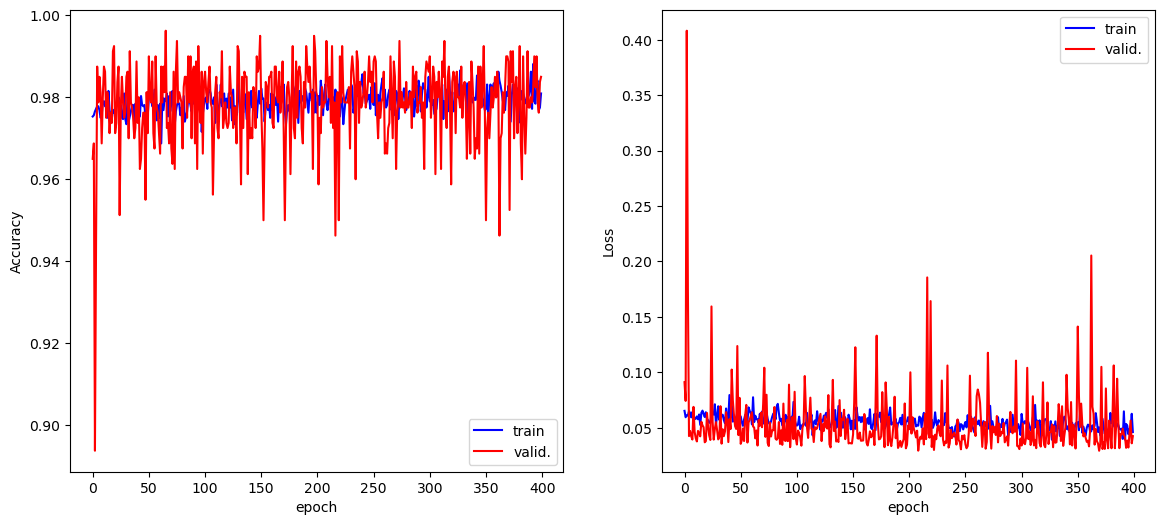

In [29]:
# plot performance

fig,AX=plt.subplots(1,2,figsize=(14,6.))

ax=AX[0]
ax.plot(final_model_dsitribution_1.history['accuracy'],label="train",c="b")
ax.plot(final_model_dsitribution_1.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()

ax=AX[1]
ax.plot(final_model_dsitribution_1.history['loss'],label="train",c="b")
ax.plot(final_model_dsitribution_1.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

### 1.5 Make the prediction

82/82 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'prediction')

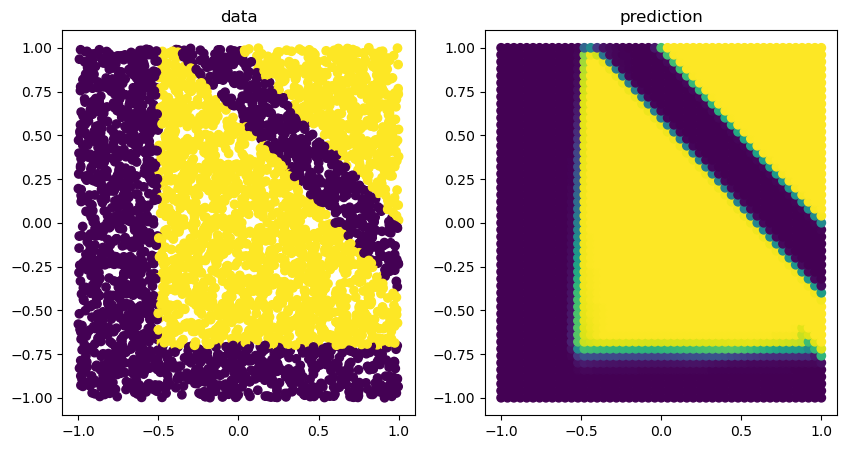

In [30]:
#Predict the possible labels of the grid created previously using the final_model_distribution 1 and plot
pred_optimized = model_1.predict(grid_r)

fig, axis = plt.subplots(1, 2, figsize=(10,5))

#Raw data
axis[0].scatter(x1[:,0]/50,x1[:,1]/50,c=y1)
axis[0].set_title("data")

#Generated with optimization
axis[1].scatter(grid_r[:,0],grid_r[:,1],c=pred_optimized)
axis[1].set_title("prediction")

# Problem 2

- Using the best DNN from the previous section we study how the performance changes when the number N of samples

In [32]:
# random seed for reproducibility
np.random.seed(123456)

#split_data_training_validation(data, labels,perc_train)

### a) decrease

In [131]:
N_a = 2000

# take from the previous training set and sample randomly 2000
permutation = np.random.permutation(x1.shape[0])

X_a = x1[permutation][:N_a]
y_a = y1[permutation][:N_a]

x1_train_a, y1_train_a, x1_val_a, y1_val_a = split_data_training_validation(X_a,y_a, 0.8)

#Normalize data
x1_train_a=Rescale(x1_train_a)
x1_val_a=Rescale(x1_val_a)

print("Train:",len(x1_train_a),"\t Validation:",len(x1_val_a))

Train: 1600 	 Validation: 400


In [132]:
#best_parameters
best_params = {'model__activation': 'relu', 'optimizer': 'SGD'}

# initialize model
model_1 = create_model(layers=3, 
                       optimizer= params['optimizer'], 
                       activation=params['model__activation'], 
                       dropout_rate=0.01, 
                       neurons = 20
                      )

# random seed for reproducibility
np.random.seed(123456+1)

# fit model
d1_model_a = model_1.fit(x1_train_a, y1_train_a,
               epochs = 500, batch_size = 60,
               validation_data=(x1_val_a, y1_val_a),
               verbose=0)

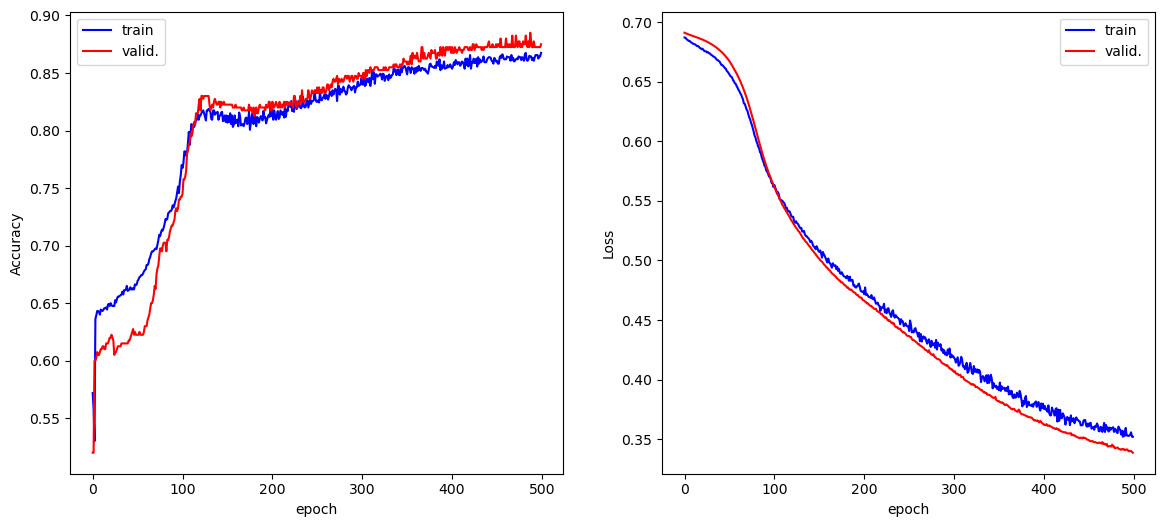

In [133]:
# plot performance

fig,AX=plt.subplots(1,2,figsize=(14,6.))
d1_model_a
ax=AX[0]
ax.plot(d1_model_a.history['accuracy'],label="train",c="b")
ax.plot(d1_model_a.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()

ax=AX[1]
ax.plot(d1_model_a.history['loss'],label="train",c="b")
ax.plot(d1_model_a.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

82/82 [==============================] - 0s 936us/step


Text(0.5, 1.0, 'prediction')

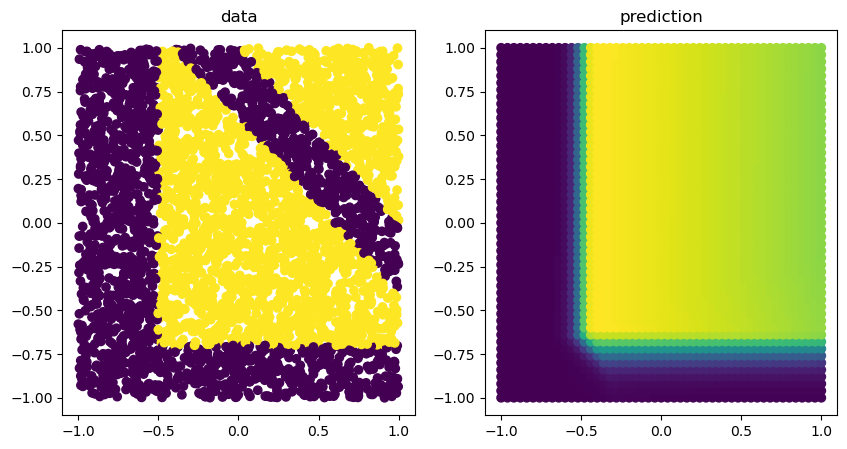

In [134]:
#Predict the possible labels of the grid created previously using the final_model_distribution 1 and plot
pred_optimized = model_1.predict(grid_r)

fig, axis = plt.subplots(1, 2, figsize=(10,5))

#Raw data
axis[0].scatter(x1[:,0]/50,x1[:,1]/50,c=y1)
axis[0].set_title("data")

#Generated with optimization
axis[1].scatter(grid_r[:,0],grid_r[:,1],c=pred_optimized)
axis[1].set_title("prediction")

### b) increase

In [135]:
N_b = 6000
x1_b, y1_b = generate_data(1,N_b)
x1_train_b, y1_train_b, x1_val_b, y1_val_b = split_data_training_validation(x1_b, y1_b, 0.8)

#Normalize data
x1_train_b=Rescale(x1_train_b)
x1_val_b=Rescale(x1_val_b)

print("Train:",len(x1_train_b),"\t Validation:",len(x1_val_b))

Train: 4800 	 Validation: 1200


In [136]:
#best_parameters
best_params = {'model__activation': 'relu', 'optimizer': 'SGD'}

# initialize model
model_1 = create_model(layers=3, 
                       optimizer= params['optimizer'], 
                       activation=params['model__activation'], 
                       dropout_rate=0.01, 
                       neurons = 20
                      )

# random seed for reproducibility
np.random.seed(123456+2)

# fit model
d1_model_b = model_1.fit(x1_train_b, y1_train_b,
               epochs = 500, batch_size = 60,
               validation_data=(x1_val_b, y1_val_b),
               verbose=0)

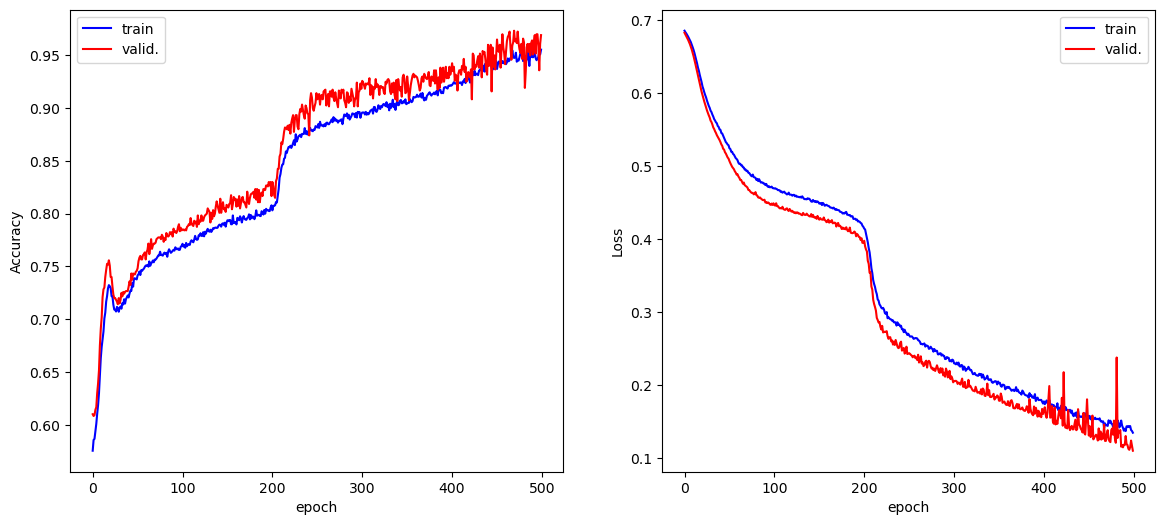

In [137]:
# plot performance

fig,AX=plt.subplots(1,2,figsize=(14,6.))

ax=AX[0]
ax.plot(d1_model_b.history['accuracy'],label="train",c="b")
ax.plot(d1_model_b.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()

ax=AX[1]
ax.plot(d1_model_b.history['loss'],label="train",c="b")
ax.plot(d1_model_b.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

82/82 [==============================] - 0s 948us/step


Text(0.5, 1.0, 'prediction')

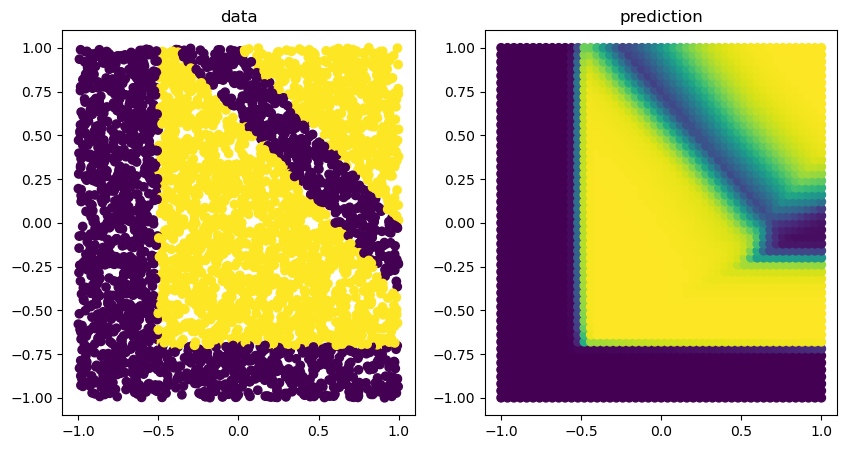

In [138]:
#Predict the possible labels of the grid created previously using the final_model_distribution 1 and plot
pred_optimized = model_1.predict(grid_r)

fig, axis = plt.subplots(1, 2, figsize=(10,5))

#Raw data
axis[0].scatter(x1[:,0]/50,x1[:,1]/50,c=y1)
axis[0].set_title("data")

#Generated with optimization
axis[1].scatter(grid_r[:,0],grid_r[:,1],c=pred_optimized)
axis[1].set_title("prediction")

### c) augmented

In [127]:
#N_c = 4000
#x1_c, y1_c = generate_data(1,N_c)
x1_train_c, y1_train_c, x1_val_c, y1_val_c = split_data_training_validation(x1, y1, 0.8)

# random seed for reproducibility
np.random.seed(123456+3)

# shift on training set
x1_train_c_shift = x1_train_c + np.random.normal(0,0.01,size=x1_train_c.shape)
print(x1_train_c_shift.shape)
x1_train_c = np.vstack([x1_train_c,x1_train_c_shift])
print(x1_train_c.shape)

y1_train_c_shift = y1_train_c + np.random.normal(0,0.01,size=y1_train_c.shape)
print(y1_train_c_shift.shape)
y1_train_c = np.concatenate([y1_train_c,y1_train_c_shift])
print(y1_train_c.shape)

# Shuffle the training data
shuffle_idx = np.random.permutation(len(x1_train_c))
x1_train_c = x1_train_c[shuffle_idx]
y1_train_c = y1_train_c[shuffle_idx]

#Normalize data
x1_train_c=Rescale(x1_train_c)
x1_val_c=Rescale(x1_val_c)

print("Train:",len(x1_train_c),"\t Validation:",len(x1_val_c))

(3200, 2)
(6400, 2)
(3200,)
(6400,)
Train: 6400 	 Validation: 800


In [128]:
#best_parameters
best_params = {'model__activation': 'relu', 'optimizer': 'SGD'}

# initialize model
model_1 = create_model(layers=3, 
                       optimizer= params['optimizer'], 
                       activation=params['model__activation'], 
                       dropout_rate=0.01, 
                       neurons = 20
                      )

# random seed for reproducibility
np.random.seed(123456+4)

# fit model
d1_model_c = model_1.fit(x1_train_c, y1_train_c,
               epochs = 500, batch_size = 60,
               validation_data=(x1_val_c, y1_val_c),
               verbose=0)

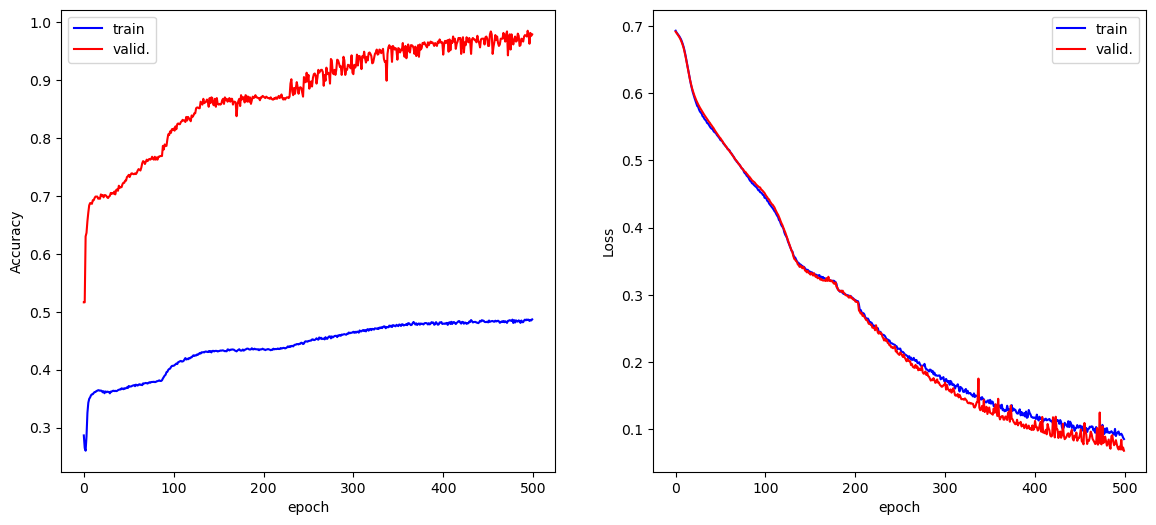

In [129]:
# plot performance

fig,AX=plt.subplots(1,2,figsize=(14,6.))

ax=AX[0]
ax.plot(d1_model_c.history['accuracy'],label="train",c="b")
ax.plot(d1_model_c.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()

ax=AX[1]
ax.plot(d1_model_c.history['loss'],label="train",c="b")
ax.plot(d1_model_c.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

82/82 [==============================] - 0s 1ms/step


Text(0.5, 1.0, 'prediction')

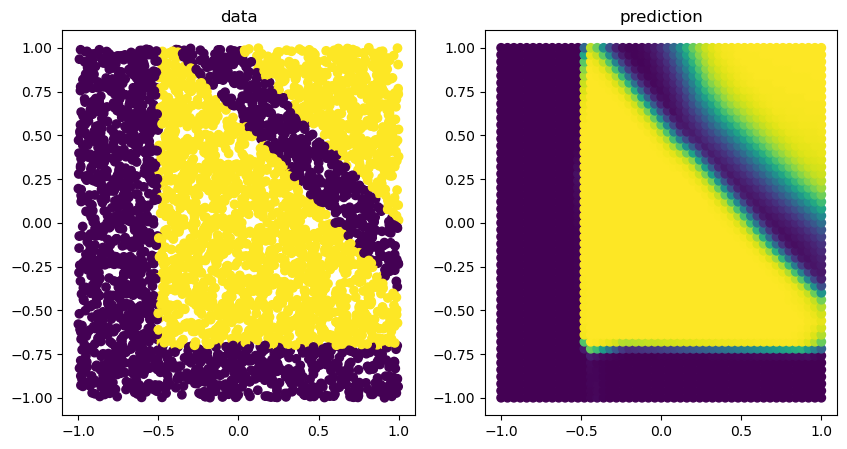

In [130]:
#Predict the possible labels of the grid created previously using the final_model_distribution 1 and plot
pred_optimized = model_1.predict(grid_r)

fig, axis = plt.subplots(1, 2, figsize=(10,5))

#Raw data
axis[0].scatter(x1[:,0]/50,x1[:,1]/50,c=y1)
axis[0].set_title("data")

#Generated with optimization
axis[1].scatter(grid_r[:,0],grid_r[:,1],c=pred_optimized)
axis[1].set_title("prediction")

In [ ]:
# Explain your choice for the variability of this
#shift. Why do not we also augment the validation samples?

The goal is to generate samples that are similar to the "real" ones, but not identical, in order to improve the robustness of the model by adding more data and diversifying the training dataset.

As for why we don't augment the validation samples, it's because we want the validation set to be a true reflection of the "real-world" data that the model will encounter. Augmenting the validation set would defeat this purpose, as it would introduce artificial samples that the model has already seen during training, making the validation set less representative of the real-world data

# Problem 3 (optional)

### 3.1 Optimization for distribution 2

- Using data from distribution 2, find the best hyperparameters

In [142]:
#Parameters in DNN 1 does not work well here, rewrite them (increase neurons, batch_sixe and epochs)
#batch_size = [30,60,90]
#epochs = [500, 1000, 1500]
neurons = [60,90 ,120]

optimizer = ["SGD", "Adagrad",  "adam",  "Nadam", "RMSprop", "Nesterov"]
activation = ["softmax",  "relu", "tanh", "sigmoid", "linear"]

In [ ]:
#create model 
model = KerasClassifier(model=create_model,
                        batch_size=60,
                        epochs=1500
                       )

#Select which ones will be used in the GridSearchCV
#If batch_size or epochs is commented, then it must be written directly in the KerasClassifier
param_grid = dict(
                  #batch_size = batch_size,
                  #epochs=epochs,
                  optimizer=optimizer,
                  model__activation=activation,
                  #model__dropout_rate=dropout_rate,
                  #layers=layers,
                  model__neurons=neurons
                  #model__init_mode=init_mode
                   )

#n_iter is the number of combinations to be done
#Random grid selects n_iter combinations from the given parameters and test them.
grid_2 = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1, n_iter=2, cv=3, verbose=1)
grid_result=grid_2.fit(x2,y2)

Notes: 
- After several trails, we have found it was necessary to use a higher number of epochs. We decided to set the epochs to 1500 and to the batch_size to 50. 
- For the parameter tuning, we decided to optimize the number of neurons among with the optimization algorithm and activation function.

In [143]:
#create model 
model = KerasClassifier(model=create_model, 
                        batch_size=50,
                        epochs=1500,
                        )

#Select which ones will be used in the GridSearchCV
#If batch_size or epochs is commented, then it must be written directly in the KerasClassifier
param_grid = dict(#batch_size = batch_size,
                  #epochs=epochs,
                  optimizer=optimizer,
                  model__activation=activation,
                  #model__dropout_rate= dropout_rate #it's set as 0.2 by default in create_model
                  #layers=layers
                  model__neurons=neurons
                  #model__init_mode=init_mode
                )

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3,verbose=2)
grid_result=grid.fit(x2,y2)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


C:\Users\fap_9\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/1500
80/80 [==============================] - 2s 3ms/step - loss: 0.7020 - accuracy: 0.5153
Epoch 2/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.6872 - accuracy: 0.5428
Epoch 3/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.6886 - accuracy: 0.5420
Epoch 4/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5458
Epoch 5/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.6832 - accuracy: 0.5380
Epoch 6/1500
80/80 [==============================] - 0s 4ms/step - loss: 0.6827 - accuracy: 0.5445
Epoch 7/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.6823 - accuracy: 0.5505
Epoch 8/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.6795 - accuracy: 0.5515
Epoch 9/1500
80/80 [==============================] - 0s 4ms/step - loss: 0.6829 - accuracy: 0.5483
Epoch 10/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.6779 - accuracy: 0.5585

80/80 [==============================] - 0s 3ms/step - loss: 0.6165 - accuracy: 0.6355
Epoch 83/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.6097 - accuracy: 0.6535
Epoch 84/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.6084 - accuracy: 0.6485
Epoch 85/1500
80/80 [==============================] - 0s 4ms/step - loss: 0.6081 - accuracy: 0.6475
Epoch 86/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.6011 - accuracy: 0.6407
Epoch 87/1500
80/80 [==============================] - 0s 1ms/step - loss: 0.5972 - accuracy: 0.6635
Epoch 88/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.5899 - accuracy: 0.6653
Epoch 89/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.5901 - accuracy: 0.6685
Epoch 90/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.5885 - accuracy: 0.6643
Epoch 91/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.5875 - accuracy: 0.6600
Epoc

80/80 [==============================] - 0s 3ms/step - loss: 0.5121 - accuracy: 0.6930
Epoch 163/1500
80/80 [==============================] - 0s 4ms/step - loss: 0.5094 - accuracy: 0.6988
Epoch 164/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.5109 - accuracy: 0.6917
Epoch 165/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.5138 - accuracy: 0.6842
Epoch 166/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.5148 - accuracy: 0.6975
Epoch 167/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.5172 - accuracy: 0.6967
Epoch 168/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.5080 - accuracy: 0.7053
Epoch 169/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.5151 - accuracy: 0.6845
Epoch 170/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.5094 - accuracy: 0.6870
Epoch 171/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.5155 - accuracy: 0.

80/80 [==============================] - 0s 3ms/step - loss: 0.4917 - accuracy: 0.7048
Epoch 243/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.5025 - accuracy: 0.6945
Epoch 244/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4857 - accuracy: 0.7053
Epoch 245/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4911 - accuracy: 0.7042
Epoch 246/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4972 - accuracy: 0.7010
Epoch 247/1500
80/80 [==============================] - 0s 4ms/step - loss: 0.4930 - accuracy: 0.7078
Epoch 248/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.5014 - accuracy: 0.7078
Epoch 249/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4950 - accuracy: 0.6945
Epoch 250/1500
80/80 [==============================] - 0s 4ms/step - loss: 0.5009 - accuracy: 0.7005
Epoch 251/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4937 - accuracy: 0.

80/80 [==============================] - 0s 3ms/step - loss: 0.4802 - accuracy: 0.7017
Epoch 323/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4790 - accuracy: 0.6990
Epoch 324/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4812 - accuracy: 0.7095
Epoch 325/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4789 - accuracy: 0.7092
Epoch 326/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4790 - accuracy: 0.7048
Epoch 327/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4780 - accuracy: 0.7005
Epoch 328/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.4863 - accuracy: 0.7040
Epoch 329/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4759 - accuracy: 0.7155
Epoch 330/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4842 - accuracy: 0.7025
Epoch 331/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.4830 - accuracy: 0.

80/80 [==============================] - 0s 3ms/step - loss: 0.4678 - accuracy: 0.7090
Epoch 403/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4703 - accuracy: 0.7150
Epoch 404/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4761 - accuracy: 0.7048
Epoch 405/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4791 - accuracy: 0.6998
Epoch 406/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.4778 - accuracy: 0.7060
Epoch 407/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4693 - accuracy: 0.7180
Epoch 408/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4691 - accuracy: 0.7130
Epoch 409/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4750 - accuracy: 0.7125
Epoch 410/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4798 - accuracy: 0.7075
Epoch 411/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4762 - accuracy: 0.

80/80 [==============================] - 0s 3ms/step - loss: 0.4671 - accuracy: 0.7048
Epoch 483/1500
80/80 [==============================] - 0s 4ms/step - loss: 0.4634 - accuracy: 0.7145
Epoch 484/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4660 - accuracy: 0.7030
Epoch 485/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4728 - accuracy: 0.6998
Epoch 486/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4656 - accuracy: 0.7082
Epoch 487/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4602 - accuracy: 0.7130
Epoch 488/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4671 - accuracy: 0.7095
Epoch 489/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4630 - accuracy: 0.7125
Epoch 490/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4613 - accuracy: 0.7090
Epoch 491/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4604 - accuracy: 0.

80/80 [==============================] - 0s 3ms/step - loss: 0.4590 - accuracy: 0.7088
Epoch 563/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4570 - accuracy: 0.7193
Epoch 564/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4516 - accuracy: 0.7168
Epoch 565/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4599 - accuracy: 0.7117
Epoch 566/1500
80/80 [==============================] - 0s 4ms/step - loss: 0.4563 - accuracy: 0.7117
Epoch 567/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4569 - accuracy: 0.7105
Epoch 568/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4588 - accuracy: 0.7143
Epoch 569/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4545 - accuracy: 0.7088
Epoch 570/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4565 - accuracy: 0.7207
Epoch 571/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4531 - accuracy: 0.

80/80 [==============================] - 0s 3ms/step - loss: 0.4488 - accuracy: 0.7180
Epoch 643/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4489 - accuracy: 0.7197
Epoch 644/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4471 - accuracy: 0.7228
Epoch 645/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4524 - accuracy: 0.7207
Epoch 646/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4468 - accuracy: 0.7165
Epoch 647/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4432 - accuracy: 0.7215
Epoch 648/1500
80/80 [==============================] - 0s 4ms/step - loss: 0.4466 - accuracy: 0.7003
Epoch 649/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4461 - accuracy: 0.7055
Epoch 650/1500
80/80 [==============================] - 0s 4ms/step - loss: 0.4466 - accuracy: 0.7163
Epoch 651/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4379 - accuracy: 0.

80/80 [==============================] - 0s 2ms/step - loss: 0.4403 - accuracy: 0.7207
Epoch 723/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.4365 - accuracy: 0.7333
Epoch 724/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.4372 - accuracy: 0.7168
Epoch 725/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.4433 - accuracy: 0.7195
Epoch 726/1500
80/80 [==============================] - 0s 1ms/step - loss: 0.4337 - accuracy: 0.7255
Epoch 727/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.4342 - accuracy: 0.7283
Epoch 728/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4410 - accuracy: 0.7170
Epoch 729/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.4449 - accuracy: 0.7153
Epoch 730/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4525 - accuracy: 0.7222
Epoch 731/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.4384 - accuracy: 0.

80/80 [==============================] - 0s 2ms/step - loss: 0.4296 - accuracy: 0.7200
Epoch 803/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.4374 - accuracy: 0.7268
Epoch 804/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.4351 - accuracy: 0.7250
Epoch 805/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.4339 - accuracy: 0.7120
Epoch 806/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.4364 - accuracy: 0.7182
Epoch 807/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.4286 - accuracy: 0.7318
Epoch 808/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4260 - accuracy: 0.7327
Epoch 809/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4286 - accuracy: 0.7195
Epoch 810/1500
80/80 [==============================] - 0s 4ms/step - loss: 0.4308 - accuracy: 0.7310
Epoch 811/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4371 - accuracy: 0.

80/80 [==============================] - 0s 3ms/step - loss: 0.4262 - accuracy: 0.7240
Epoch 883/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4249 - accuracy: 0.7270
Epoch 884/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4290 - accuracy: 0.7303
Epoch 885/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4229 - accuracy: 0.7205
Epoch 886/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4274 - accuracy: 0.7295
Epoch 887/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4297 - accuracy: 0.7253
Epoch 888/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4243 - accuracy: 0.7270
Epoch 889/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4292 - accuracy: 0.7222
Epoch 890/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4224 - accuracy: 0.7335
Epoch 891/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4228 - accuracy: 0.

80/80 [==============================] - 0s 3ms/step - loss: 0.4129 - accuracy: 0.7410
Epoch 963/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4205 - accuracy: 0.7305
Epoch 964/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4168 - accuracy: 0.7383
Epoch 965/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4169 - accuracy: 0.7352
Epoch 966/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4140 - accuracy: 0.7355
Epoch 967/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4183 - accuracy: 0.7345
Epoch 968/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4149 - accuracy: 0.7370
Epoch 969/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4304 - accuracy: 0.7258
Epoch 970/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4187 - accuracy: 0.7232
Epoch 971/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4146 - accuracy: 0.

80/80 [==============================] - 0s 3ms/step - loss: 0.4037 - accuracy: 0.7442
Epoch 1043/1500
80/80 [==============================] - 0s 4ms/step - loss: 0.3999 - accuracy: 0.7372
Epoch 1044/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4095 - accuracy: 0.7393
Epoch 1045/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4148 - accuracy: 0.7347
Epoch 1046/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4135 - accuracy: 0.7383
Epoch 1047/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4046 - accuracy: 0.7410
Epoch 1048/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4077 - accuracy: 0.7305
Epoch 1049/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4081 - accuracy: 0.7387
Epoch 1050/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4206 - accuracy: 0.7293
Epoch 1051/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4158 - acc

80/80 [==============================] - 0s 3ms/step - loss: 0.4010 - accuracy: 0.7423
Epoch 1122/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4026 - accuracy: 0.7430
Epoch 1123/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.3954 - accuracy: 0.7440
Epoch 1124/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.3935 - accuracy: 0.7410
Epoch 1125/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.4079 - accuracy: 0.7427
Epoch 1126/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.4074 - accuracy: 0.7418
Epoch 1127/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.3934 - accuracy: 0.7448
Epoch 1128/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.3984 - accuracy: 0.7452
Epoch 1129/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4019 - accuracy: 0.7420
Epoch 1130/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4013 - acc

80/80 [==============================] - 0s 2ms/step - loss: 0.3928 - accuracy: 0.7458
Epoch 1201/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.3863 - accuracy: 0.7452
Epoch 1202/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.3981 - accuracy: 0.7383
Epoch 1203/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.3962 - accuracy: 0.7410
Epoch 1204/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.3954 - accuracy: 0.7538
Epoch 1205/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.3843 - accuracy: 0.7430
Epoch 1206/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.3937 - accuracy: 0.7495
Epoch 1207/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.3857 - accuracy: 0.7492
Epoch 1208/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.3936 - accuracy: 0.7523
Epoch 1209/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.3866 - acc

80/80 [==============================] - 0s 3ms/step - loss: 0.3940 - accuracy: 0.7445
Epoch 1280/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.3908 - accuracy: 0.7462
Epoch 1281/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4185 - accuracy: 0.7347
Epoch 1282/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4030 - accuracy: 0.7483
Epoch 1283/1500
80/80 [==============================] - 0s 4ms/step - loss: 0.3994 - accuracy: 0.7510
Epoch 1284/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.3857 - accuracy: 0.7550
Epoch 1285/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.4070 - accuracy: 0.7377
Epoch 1286/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.3925 - accuracy: 0.7508
Epoch 1287/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.3857 - accuracy: 0.7505
Epoch 1288/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.3844 - acc

80/80 [==============================] - 0s 3ms/step - loss: 0.3701 - accuracy: 0.7580
Epoch 1359/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.3702 - accuracy: 0.7607
Epoch 1360/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.4058 - accuracy: 0.7490
Epoch 1361/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.3846 - accuracy: 0.7548
Epoch 1362/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.3799 - accuracy: 0.7548
Epoch 1363/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.3754 - accuracy: 0.7615
Epoch 1364/1500
80/80 [==============================] - 0s 2ms/step - loss: 0.3977 - accuracy: 0.7500
Epoch 1365/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.3724 - accuracy: 0.7602
Epoch 1366/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.3779 - accuracy: 0.7590
Epoch 1367/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.3761 - acc

80/80 [==============================] - 0s 3ms/step - loss: 0.3779 - accuracy: 0.7582
Epoch 1438/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.3797 - accuracy: 0.7628
Epoch 1439/1500
80/80 [==============================] - 0s 4ms/step - loss: 0.3716 - accuracy: 0.7577
Epoch 1440/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.3731 - accuracy: 0.7642
Epoch 1441/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.3769 - accuracy: 0.7632
Epoch 1442/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.3660 - accuracy: 0.7665
Epoch 1443/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.3735 - accuracy: 0.7632
Epoch 1444/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.3709 - accuracy: 0.7615
Epoch 1445/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.3696 - accuracy: 0.7585
Epoch 1446/1500
80/80 [==============================] - 0s 3ms/step - loss: 0.3742 - acc

In [144]:
#best parameters for getting high accuracy
best_parameters = grid_result.best_params_
print("The best combination of hyperparameters is: {}".format(best_parameters))
#highest accuracy for previous values
highest_accuracy = grid_result.best_score_
print("The accuracy obtained for those previous values is: {}".format(highest_accuracy))

The best combination of hyperparameters is: {'model__activation': 'relu', 'model__neurons': 90, 'optimizer': 'Nadam'}
The accuracy obtained for those previous values is: 0.7547435959439635


### Test accuracy with distribution 2

In [145]:
#Split data for distribution 1 in training and validation 
d2_train_data, d2_train_label, d2_val_data, d2_val_label = split_data_training_validation(x2, y2, 0.8)

#Normalize data
d2_train_data=Rescale(d2_train_data)
d2_val_data=Rescale(d2_val_data)

print("Train:",len(d2_train_data),"\t Validation:",len(d2_val_data))

Train: 3200 	 Validation: 800


In [146]:
# best parameters for distribution 2
params = {'model__activation': 'relu', 'model__neurons': 90, 'optimizer': 'Nadam'}

In [150]:
model_2 = create_model(layers=3, 
                       optimizer= params['optimizer'], 
                       activation=params['model__activation'], 
                       dropout_rate=0.01, 
                       neurons = params['model__neurons']
                      )

# results
model_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 2)                 6         
                                                                 
 dense_33 (Dense)            (None, 20)                60        
                                                                 
 dense_34 (Dense)            (None, 20)                420       
                                                                 
 dropout_8 (Dropout)         (None, 20)                0         
                                                                 
 dense_35 (Dense)            (None, 1)                 21        
                                                                 
Total params: 507
Trainable params: 507
Non-trainable params: 0
_________________________________________________________________


In [152]:
final_model_dsitribution_2= model_2.fit(d2_train_data, d2_train_label, 
               epochs = 1500, batch_size = 60,
               validation_data=(d2_val_data, d2_val_label),
               verbose=2)

Epoch 1/1500
54/54 - 4s - loss: 0.6923 - accuracy: 0.5106 - val_loss: 0.6875 - val_accuracy: 0.5525 - 4s/epoch - 73ms/step
Epoch 2/1500
54/54 - 0s - loss: 0.6898 - accuracy: 0.5375 - val_loss: 0.6877 - val_accuracy: 0.5387 - 332ms/epoch - 6ms/step
Epoch 3/1500
54/54 - 0s - loss: 0.6887 - accuracy: 0.5409 - val_loss: 0.6853 - val_accuracy: 0.5537 - 333ms/epoch - 6ms/step
Epoch 4/1500
54/54 - 0s - loss: 0.6865 - accuracy: 0.5466 - val_loss: 0.6815 - val_accuracy: 0.5537 - 358ms/epoch - 7ms/step
Epoch 5/1500
54/54 - 0s - loss: 0.6849 - accuracy: 0.5566 - val_loss: 0.6797 - val_accuracy: 0.5688 - 341ms/epoch - 6ms/step
Epoch 6/1500
54/54 - 0s - loss: 0.6844 - accuracy: 0.5456 - val_loss: 0.6803 - val_accuracy: 0.5675 - 330ms/epoch - 6ms/step
Epoch 7/1500
54/54 - 0s - loss: 0.6825 - accuracy: 0.5553 - val_loss: 0.6774 - val_accuracy: 0.5688 - 346ms/epoch - 6ms/step
Epoch 8/1500
54/54 - 0s - loss: 0.6815 - accuracy: 0.5544 - val_loss: 0.6772 - val_accuracy: 0.5675 - 358ms/epoch - 7ms/step
Ep

54/54 - 0s - loss: 0.5640 - accuracy: 0.6784 - val_loss: 0.5646 - val_accuracy: 0.6787 - 332ms/epoch - 6ms/step
Epoch 67/1500
54/54 - 0s - loss: 0.5632 - accuracy: 0.6744 - val_loss: 0.5563 - val_accuracy: 0.6862 - 339ms/epoch - 6ms/step
Epoch 68/1500
54/54 - 0s - loss: 0.5608 - accuracy: 0.6731 - val_loss: 0.5548 - val_accuracy: 0.6700 - 316ms/epoch - 6ms/step
Epoch 69/1500
54/54 - 0s - loss: 0.5583 - accuracy: 0.6741 - val_loss: 0.5555 - val_accuracy: 0.6737 - 322ms/epoch - 6ms/step
Epoch 70/1500
54/54 - 0s - loss: 0.5552 - accuracy: 0.6828 - val_loss: 0.5526 - val_accuracy: 0.6800 - 344ms/epoch - 6ms/step
Epoch 71/1500
54/54 - 0s - loss: 0.5542 - accuracy: 0.6819 - val_loss: 0.5589 - val_accuracy: 0.6637 - 359ms/epoch - 7ms/step
Epoch 72/1500
54/54 - 0s - loss: 0.5526 - accuracy: 0.6881 - val_loss: 0.5517 - val_accuracy: 0.6650 - 369ms/epoch - 7ms/step
Epoch 73/1500
54/54 - 0s - loss: 0.5530 - accuracy: 0.6728 - val_loss: 0.5481 - val_accuracy: 0.6762 - 340ms/epoch - 6ms/step
Epoch 

Epoch 131/1500
54/54 - 0s - loss: 0.4880 - accuracy: 0.7116 - val_loss: 0.4786 - val_accuracy: 0.7150 - 319ms/epoch - 6ms/step
Epoch 132/1500
54/54 - 0s - loss: 0.4855 - accuracy: 0.7200 - val_loss: 0.4785 - val_accuracy: 0.7250 - 357ms/epoch - 7ms/step
Epoch 133/1500
54/54 - 0s - loss: 0.4834 - accuracy: 0.7172 - val_loss: 0.5052 - val_accuracy: 0.6950 - 319ms/epoch - 6ms/step
Epoch 134/1500
54/54 - 0s - loss: 0.4853 - accuracy: 0.7216 - val_loss: 0.4789 - val_accuracy: 0.7175 - 312ms/epoch - 6ms/step
Epoch 135/1500
54/54 - 0s - loss: 0.4787 - accuracy: 0.7194 - val_loss: 0.4717 - val_accuracy: 0.7200 - 280ms/epoch - 5ms/step
Epoch 136/1500
54/54 - 0s - loss: 0.4820 - accuracy: 0.7134 - val_loss: 0.4780 - val_accuracy: 0.7138 - 323ms/epoch - 6ms/step
Epoch 137/1500
54/54 - 0s - loss: 0.4786 - accuracy: 0.7225 - val_loss: 0.4744 - val_accuracy: 0.7138 - 334ms/epoch - 6ms/step
Epoch 138/1500
54/54 - 0s - loss: 0.4776 - accuracy: 0.7153 - val_loss: 0.4818 - val_accuracy: 0.7025 - 311ms/e

Epoch 196/1500
54/54 - 0s - loss: 0.4125 - accuracy: 0.7834 - val_loss: 0.4143 - val_accuracy: 0.7713 - 327ms/epoch - 6ms/step
Epoch 197/1500
54/54 - 0s - loss: 0.4108 - accuracy: 0.7872 - val_loss: 0.4199 - val_accuracy: 0.7588 - 312ms/epoch - 6ms/step
Epoch 198/1500
54/54 - 0s - loss: 0.4134 - accuracy: 0.7853 - val_loss: 0.4349 - val_accuracy: 0.7600 - 331ms/epoch - 6ms/step
Epoch 199/1500
54/54 - 0s - loss: 0.4147 - accuracy: 0.7788 - val_loss: 0.4186 - val_accuracy: 0.7638 - 349ms/epoch - 6ms/step
Epoch 200/1500
54/54 - 0s - loss: 0.4077 - accuracy: 0.7819 - val_loss: 0.4355 - val_accuracy: 0.7575 - 344ms/epoch - 6ms/step
Epoch 201/1500
54/54 - 0s - loss: 0.4073 - accuracy: 0.7850 - val_loss: 0.4122 - val_accuracy: 0.7688 - 334ms/epoch - 6ms/step
Epoch 202/1500
54/54 - 0s - loss: 0.4097 - accuracy: 0.7872 - val_loss: 0.4170 - val_accuracy: 0.7688 - 324ms/epoch - 6ms/step
Epoch 203/1500
54/54 - 0s - loss: 0.4069 - accuracy: 0.7897 - val_loss: 0.4117 - val_accuracy: 0.7650 - 325ms/e

Epoch 261/1500
54/54 - 0s - loss: 0.3516 - accuracy: 0.8331 - val_loss: 0.3472 - val_accuracy: 0.8425 - 317ms/epoch - 6ms/step
Epoch 262/1500
54/54 - 0s - loss: 0.3532 - accuracy: 0.8331 - val_loss: 0.3438 - val_accuracy: 0.8425 - 342ms/epoch - 6ms/step
Epoch 263/1500
54/54 - 0s - loss: 0.3504 - accuracy: 0.8341 - val_loss: 0.3473 - val_accuracy: 0.8350 - 351ms/epoch - 6ms/step
Epoch 264/1500
54/54 - 0s - loss: 0.3526 - accuracy: 0.8331 - val_loss: 0.3547 - val_accuracy: 0.8313 - 347ms/epoch - 6ms/step
Epoch 265/1500
54/54 - 0s - loss: 0.3480 - accuracy: 0.8416 - val_loss: 0.3675 - val_accuracy: 0.8263 - 344ms/epoch - 6ms/step
Epoch 266/1500
54/54 - 0s - loss: 0.3489 - accuracy: 0.8384 - val_loss: 0.3443 - val_accuracy: 0.8400 - 351ms/epoch - 6ms/step
Epoch 267/1500
54/54 - 0s - loss: 0.3473 - accuracy: 0.8400 - val_loss: 0.3409 - val_accuracy: 0.8562 - 328ms/epoch - 6ms/step
Epoch 268/1500
54/54 - 0s - loss: 0.3479 - accuracy: 0.8306 - val_loss: 0.3446 - val_accuracy: 0.8150 - 326ms/e

Epoch 326/1500
54/54 - 0s - loss: 0.3229 - accuracy: 0.8572 - val_loss: 0.3279 - val_accuracy: 0.8438 - 316ms/epoch - 6ms/step
Epoch 327/1500
54/54 - 0s - loss: 0.3213 - accuracy: 0.8500 - val_loss: 0.3219 - val_accuracy: 0.8512 - 299ms/epoch - 6ms/step
Epoch 328/1500
54/54 - 0s - loss: 0.3213 - accuracy: 0.8550 - val_loss: 0.3264 - val_accuracy: 0.8500 - 299ms/epoch - 6ms/step
Epoch 329/1500
54/54 - 0s - loss: 0.3201 - accuracy: 0.8541 - val_loss: 0.3280 - val_accuracy: 0.8475 - 313ms/epoch - 6ms/step
Epoch 330/1500
54/54 - 0s - loss: 0.3222 - accuracy: 0.8525 - val_loss: 0.3219 - val_accuracy: 0.8475 - 314ms/epoch - 6ms/step
Epoch 331/1500
54/54 - 0s - loss: 0.3231 - accuracy: 0.8497 - val_loss: 0.3164 - val_accuracy: 0.8475 - 322ms/epoch - 6ms/step
Epoch 332/1500
54/54 - 0s - loss: 0.3237 - accuracy: 0.8509 - val_loss: 0.3204 - val_accuracy: 0.8462 - 298ms/epoch - 6ms/step
Epoch 333/1500
54/54 - 0s - loss: 0.3222 - accuracy: 0.8466 - val_loss: 0.3389 - val_accuracy: 0.8400 - 306ms/e

Epoch 391/1500
54/54 - 0s - loss: 0.3181 - accuracy: 0.8553 - val_loss: 0.3342 - val_accuracy: 0.8288 - 354ms/epoch - 7ms/step
Epoch 392/1500
54/54 - 0s - loss: 0.3156 - accuracy: 0.8525 - val_loss: 0.3246 - val_accuracy: 0.8400 - 339ms/epoch - 6ms/step
Epoch 393/1500
54/54 - 0s - loss: 0.3100 - accuracy: 0.8581 - val_loss: 0.3185 - val_accuracy: 0.8450 - 336ms/epoch - 6ms/step
Epoch 394/1500
54/54 - 0s - loss: 0.3144 - accuracy: 0.8600 - val_loss: 0.3240 - val_accuracy: 0.8388 - 346ms/epoch - 6ms/step
Epoch 395/1500
54/54 - 0s - loss: 0.3121 - accuracy: 0.8553 - val_loss: 0.3157 - val_accuracy: 0.8438 - 343ms/epoch - 6ms/step
Epoch 396/1500
54/54 - 0s - loss: 0.3082 - accuracy: 0.8594 - val_loss: 0.3293 - val_accuracy: 0.8325 - 357ms/epoch - 7ms/step
Epoch 397/1500
54/54 - 0s - loss: 0.3129 - accuracy: 0.8562 - val_loss: 0.3341 - val_accuracy: 0.8263 - 331ms/epoch - 6ms/step
Epoch 398/1500
54/54 - 0s - loss: 0.3138 - accuracy: 0.8562 - val_loss: 0.3134 - val_accuracy: 0.8462 - 344ms/e

Epoch 456/1500
54/54 - 0s - loss: 0.3064 - accuracy: 0.8547 - val_loss: 0.3183 - val_accuracy: 0.8350 - 344ms/epoch - 6ms/step
Epoch 457/1500
54/54 - 0s - loss: 0.3040 - accuracy: 0.8591 - val_loss: 0.3486 - val_accuracy: 0.8325 - 324ms/epoch - 6ms/step
Epoch 458/1500
54/54 - 0s - loss: 0.3039 - accuracy: 0.8612 - val_loss: 0.3131 - val_accuracy: 0.8438 - 336ms/epoch - 6ms/step
Epoch 459/1500
54/54 - 0s - loss: 0.3003 - accuracy: 0.8594 - val_loss: 0.3090 - val_accuracy: 0.8450 - 308ms/epoch - 6ms/step
Epoch 460/1500
54/54 - 0s - loss: 0.3059 - accuracy: 0.8569 - val_loss: 0.3032 - val_accuracy: 0.8475 - 345ms/epoch - 6ms/step
Epoch 461/1500
54/54 - 0s - loss: 0.2992 - accuracy: 0.8578 - val_loss: 0.2997 - val_accuracy: 0.8475 - 371ms/epoch - 7ms/step
Epoch 462/1500
54/54 - 0s - loss: 0.3025 - accuracy: 0.8634 - val_loss: 0.3188 - val_accuracy: 0.8325 - 331ms/epoch - 6ms/step
Epoch 463/1500
54/54 - 0s - loss: 0.3075 - accuracy: 0.8569 - val_loss: 0.3584 - val_accuracy: 0.8238 - 314ms/e

Epoch 521/1500
54/54 - 0s - loss: 0.2931 - accuracy: 0.8616 - val_loss: 0.2992 - val_accuracy: 0.8462 - 301ms/epoch - 6ms/step
Epoch 522/1500
54/54 - 0s - loss: 0.2928 - accuracy: 0.8606 - val_loss: 0.3042 - val_accuracy: 0.8425 - 306ms/epoch - 6ms/step
Epoch 523/1500
54/54 - 0s - loss: 0.2987 - accuracy: 0.8597 - val_loss: 0.3103 - val_accuracy: 0.8425 - 260ms/epoch - 5ms/step
Epoch 524/1500
54/54 - 0s - loss: 0.2957 - accuracy: 0.8616 - val_loss: 0.3174 - val_accuracy: 0.8388 - 332ms/epoch - 6ms/step
Epoch 525/1500
54/54 - 0s - loss: 0.2936 - accuracy: 0.8656 - val_loss: 0.3221 - val_accuracy: 0.8363 - 295ms/epoch - 5ms/step
Epoch 526/1500
54/54 - 0s - loss: 0.3034 - accuracy: 0.8584 - val_loss: 0.3117 - val_accuracy: 0.8450 - 333ms/epoch - 6ms/step
Epoch 527/1500
54/54 - 0s - loss: 0.2916 - accuracy: 0.8662 - val_loss: 0.3136 - val_accuracy: 0.8388 - 356ms/epoch - 7ms/step
Epoch 528/1500
54/54 - 0s - loss: 0.2995 - accuracy: 0.8578 - val_loss: 0.3095 - val_accuracy: 0.8388 - 363ms/e

Epoch 586/1500
54/54 - 0s - loss: 0.2881 - accuracy: 0.8666 - val_loss: 0.2838 - val_accuracy: 0.8512 - 344ms/epoch - 6ms/step
Epoch 587/1500
54/54 - 0s - loss: 0.2865 - accuracy: 0.8666 - val_loss: 0.3068 - val_accuracy: 0.8375 - 357ms/epoch - 7ms/step
Epoch 588/1500
54/54 - 0s - loss: 0.2917 - accuracy: 0.8622 - val_loss: 0.3119 - val_accuracy: 0.8363 - 328ms/epoch - 6ms/step
Epoch 589/1500
54/54 - 0s - loss: 0.2891 - accuracy: 0.8584 - val_loss: 0.3282 - val_accuracy: 0.8263 - 316ms/epoch - 6ms/step
Epoch 590/1500
54/54 - 0s - loss: 0.2909 - accuracy: 0.8656 - val_loss: 0.2974 - val_accuracy: 0.8475 - 353ms/epoch - 7ms/step
Epoch 591/1500
54/54 - 0s - loss: 0.2948 - accuracy: 0.8572 - val_loss: 0.3200 - val_accuracy: 0.8338 - 331ms/epoch - 6ms/step
Epoch 592/1500
54/54 - 0s - loss: 0.2864 - accuracy: 0.8653 - val_loss: 0.3045 - val_accuracy: 0.8313 - 333ms/epoch - 6ms/step
Epoch 593/1500
54/54 - 0s - loss: 0.2833 - accuracy: 0.8628 - val_loss: 0.3088 - val_accuracy: 0.8363 - 325ms/e

Epoch 651/1500
54/54 - 0s - loss: 0.2744 - accuracy: 0.8669 - val_loss: 0.2880 - val_accuracy: 0.8550 - 338ms/epoch - 6ms/step
Epoch 652/1500
54/54 - 0s - loss: 0.2766 - accuracy: 0.8681 - val_loss: 0.2905 - val_accuracy: 0.8475 - 339ms/epoch - 6ms/step
Epoch 653/1500
54/54 - 0s - loss: 0.2760 - accuracy: 0.8684 - val_loss: 0.2873 - val_accuracy: 0.8537 - 310ms/epoch - 6ms/step
Epoch 654/1500
54/54 - 0s - loss: 0.2820 - accuracy: 0.8719 - val_loss: 0.3057 - val_accuracy: 0.8537 - 317ms/epoch - 6ms/step
Epoch 655/1500
54/54 - 0s - loss: 0.2795 - accuracy: 0.8672 - val_loss: 0.3014 - val_accuracy: 0.8413 - 304ms/epoch - 6ms/step
Epoch 656/1500
54/54 - 0s - loss: 0.2785 - accuracy: 0.8659 - val_loss: 0.2812 - val_accuracy: 0.8550 - 269ms/epoch - 5ms/step
Epoch 657/1500
54/54 - 0s - loss: 0.2766 - accuracy: 0.8694 - val_loss: 0.3030 - val_accuracy: 0.8462 - 301ms/epoch - 6ms/step
Epoch 658/1500
54/54 - 0s - loss: 0.2736 - accuracy: 0.8722 - val_loss: 0.2836 - val_accuracy: 0.8525 - 317ms/e

Epoch 716/1500
54/54 - 0s - loss: 0.2700 - accuracy: 0.8744 - val_loss: 0.2890 - val_accuracy: 0.8487 - 347ms/epoch - 6ms/step
Epoch 717/1500
54/54 - 0s - loss: 0.2784 - accuracy: 0.8656 - val_loss: 0.2868 - val_accuracy: 0.8400 - 353ms/epoch - 7ms/step
Epoch 718/1500
54/54 - 0s - loss: 0.2705 - accuracy: 0.8678 - val_loss: 0.2883 - val_accuracy: 0.8475 - 346ms/epoch - 6ms/step
Epoch 719/1500
54/54 - 0s - loss: 0.2718 - accuracy: 0.8681 - val_loss: 0.2972 - val_accuracy: 0.8537 - 358ms/epoch - 7ms/step
Epoch 720/1500
54/54 - 0s - loss: 0.2736 - accuracy: 0.8691 - val_loss: 0.2953 - val_accuracy: 0.8475 - 347ms/epoch - 6ms/step
Epoch 721/1500
54/54 - 0s - loss: 0.2699 - accuracy: 0.8737 - val_loss: 0.2743 - val_accuracy: 0.8737 - 371ms/epoch - 7ms/step
Epoch 722/1500
54/54 - 0s - loss: 0.2751 - accuracy: 0.8597 - val_loss: 0.2948 - val_accuracy: 0.8375 - 358ms/epoch - 7ms/step
Epoch 723/1500
54/54 - 0s - loss: 0.2699 - accuracy: 0.8691 - val_loss: 0.2751 - val_accuracy: 0.8675 - 379ms/e

Epoch 781/1500
54/54 - 0s - loss: 0.2718 - accuracy: 0.8653 - val_loss: 0.3177 - val_accuracy: 0.8363 - 332ms/epoch - 6ms/step
Epoch 782/1500
54/54 - 0s - loss: 0.2677 - accuracy: 0.8669 - val_loss: 0.2723 - val_accuracy: 0.8587 - 337ms/epoch - 6ms/step
Epoch 783/1500
54/54 - 0s - loss: 0.2604 - accuracy: 0.8753 - val_loss: 0.2805 - val_accuracy: 0.8487 - 329ms/epoch - 6ms/step
Epoch 784/1500
54/54 - 0s - loss: 0.2738 - accuracy: 0.8719 - val_loss: 0.2874 - val_accuracy: 0.8462 - 336ms/epoch - 6ms/step
Epoch 785/1500
54/54 - 0s - loss: 0.2734 - accuracy: 0.8659 - val_loss: 0.3153 - val_accuracy: 0.8325 - 347ms/epoch - 6ms/step
Epoch 786/1500
54/54 - 0s - loss: 0.2679 - accuracy: 0.8728 - val_loss: 0.2810 - val_accuracy: 0.8675 - 330ms/epoch - 6ms/step
Epoch 787/1500
54/54 - 0s - loss: 0.2680 - accuracy: 0.8741 - val_loss: 0.2974 - val_accuracy: 0.8525 - 331ms/epoch - 6ms/step
Epoch 788/1500
54/54 - 0s - loss: 0.2788 - accuracy: 0.8616 - val_loss: 0.2813 - val_accuracy: 0.8700 - 342ms/e

Epoch 846/1500
54/54 - 0s - loss: 0.2627 - accuracy: 0.8759 - val_loss: 0.2666 - val_accuracy: 0.8587 - 292ms/epoch - 5ms/step
Epoch 847/1500
54/54 - 0s - loss: 0.2714 - accuracy: 0.8644 - val_loss: 0.2722 - val_accuracy: 0.8537 - 304ms/epoch - 6ms/step
Epoch 848/1500
54/54 - 0s - loss: 0.2608 - accuracy: 0.8722 - val_loss: 0.2744 - val_accuracy: 0.8562 - 317ms/epoch - 6ms/step
Epoch 849/1500
54/54 - 0s - loss: 0.2606 - accuracy: 0.8709 - val_loss: 0.2914 - val_accuracy: 0.8425 - 320ms/epoch - 6ms/step
Epoch 850/1500
54/54 - 0s - loss: 0.2634 - accuracy: 0.8681 - val_loss: 0.2965 - val_accuracy: 0.8537 - 329ms/epoch - 6ms/step
Epoch 851/1500
54/54 - 0s - loss: 0.2639 - accuracy: 0.8756 - val_loss: 0.2960 - val_accuracy: 0.8462 - 321ms/epoch - 6ms/step
Epoch 852/1500
54/54 - 0s - loss: 0.2664 - accuracy: 0.8691 - val_loss: 0.2815 - val_accuracy: 0.8587 - 316ms/epoch - 6ms/step
Epoch 853/1500
54/54 - 0s - loss: 0.2512 - accuracy: 0.8819 - val_loss: 0.2619 - val_accuracy: 0.8687 - 316ms/e

Epoch 911/1500
54/54 - 0s - loss: 0.2640 - accuracy: 0.8750 - val_loss: 0.2801 - val_accuracy: 0.8550 - 352ms/epoch - 7ms/step
Epoch 912/1500
54/54 - 0s - loss: 0.2578 - accuracy: 0.8737 - val_loss: 0.2714 - val_accuracy: 0.8600 - 346ms/epoch - 6ms/step
Epoch 913/1500
54/54 - 0s - loss: 0.2602 - accuracy: 0.8725 - val_loss: 0.2835 - val_accuracy: 0.8575 - 345ms/epoch - 6ms/step
Epoch 914/1500
54/54 - 0s - loss: 0.2579 - accuracy: 0.8722 - val_loss: 0.2741 - val_accuracy: 0.8600 - 321ms/epoch - 6ms/step
Epoch 915/1500
54/54 - 0s - loss: 0.2593 - accuracy: 0.8741 - val_loss: 0.2711 - val_accuracy: 0.8675 - 329ms/epoch - 6ms/step
Epoch 916/1500
54/54 - 0s - loss: 0.2631 - accuracy: 0.8700 - val_loss: 0.2806 - val_accuracy: 0.8475 - 331ms/epoch - 6ms/step
Epoch 917/1500
54/54 - 0s - loss: 0.2581 - accuracy: 0.8744 - val_loss: 0.2782 - val_accuracy: 0.8612 - 338ms/epoch - 6ms/step
Epoch 918/1500
54/54 - 0s - loss: 0.2653 - accuracy: 0.8672 - val_loss: 0.3329 - val_accuracy: 0.8425 - 347ms/e

Epoch 976/1500
54/54 - 0s - loss: 0.2586 - accuracy: 0.8719 - val_loss: 0.2750 - val_accuracy: 0.8512 - 350ms/epoch - 6ms/step
Epoch 977/1500
54/54 - 0s - loss: 0.2497 - accuracy: 0.8763 - val_loss: 0.2752 - val_accuracy: 0.8587 - 335ms/epoch - 6ms/step
Epoch 978/1500
54/54 - 0s - loss: 0.2535 - accuracy: 0.8737 - val_loss: 0.2650 - val_accuracy: 0.8650 - 339ms/epoch - 6ms/step
Epoch 979/1500
54/54 - 0s - loss: 0.2526 - accuracy: 0.8759 - val_loss: 0.2698 - val_accuracy: 0.8637 - 336ms/epoch - 6ms/step
Epoch 980/1500
54/54 - 0s - loss: 0.2495 - accuracy: 0.8794 - val_loss: 0.2858 - val_accuracy: 0.8475 - 329ms/epoch - 6ms/step
Epoch 981/1500
54/54 - 0s - loss: 0.2542 - accuracy: 0.8781 - val_loss: 0.2699 - val_accuracy: 0.8587 - 335ms/epoch - 6ms/step
Epoch 982/1500
54/54 - 0s - loss: 0.2548 - accuracy: 0.8763 - val_loss: 0.2828 - val_accuracy: 0.8487 - 359ms/epoch - 7ms/step
Epoch 983/1500
54/54 - 0s - loss: 0.2542 - accuracy: 0.8791 - val_loss: 0.2837 - val_accuracy: 0.8475 - 355ms/e

Epoch 1041/1500
54/54 - 0s - loss: 0.2397 - accuracy: 0.8850 - val_loss: 0.3067 - val_accuracy: 0.8450 - 320ms/epoch - 6ms/step
Epoch 1042/1500
54/54 - 0s - loss: 0.2423 - accuracy: 0.8809 - val_loss: 0.3023 - val_accuracy: 0.8462 - 328ms/epoch - 6ms/step
Epoch 1043/1500
54/54 - 0s - loss: 0.2542 - accuracy: 0.8737 - val_loss: 0.2832 - val_accuracy: 0.8438 - 293ms/epoch - 5ms/step
Epoch 1044/1500
54/54 - 0s - loss: 0.2469 - accuracy: 0.8825 - val_loss: 0.2707 - val_accuracy: 0.8537 - 299ms/epoch - 6ms/step
Epoch 1045/1500
54/54 - 0s - loss: 0.2493 - accuracy: 0.8788 - val_loss: 0.2790 - val_accuracy: 0.8475 - 302ms/epoch - 6ms/step
Epoch 1046/1500
54/54 - 0s - loss: 0.2432 - accuracy: 0.8806 - val_loss: 0.2726 - val_accuracy: 0.8487 - 307ms/epoch - 6ms/step
Epoch 1047/1500
54/54 - 0s - loss: 0.2428 - accuracy: 0.8809 - val_loss: 0.2838 - val_accuracy: 0.8375 - 323ms/epoch - 6ms/step
Epoch 1048/1500
54/54 - 0s - loss: 0.2458 - accuracy: 0.8831 - val_loss: 0.2756 - val_accuracy: 0.8550 -

54/54 - 0s - loss: 0.2430 - accuracy: 0.8806 - val_loss: 0.2681 - val_accuracy: 0.8625 - 335ms/epoch - 6ms/step
Epoch 1106/1500
54/54 - 0s - loss: 0.2478 - accuracy: 0.8709 - val_loss: 0.2942 - val_accuracy: 0.8363 - 345ms/epoch - 6ms/step
Epoch 1107/1500
54/54 - 0s - loss: 0.2431 - accuracy: 0.8750 - val_loss: 0.2946 - val_accuracy: 0.8438 - 334ms/epoch - 6ms/step
Epoch 1108/1500
54/54 - 0s - loss: 0.2430 - accuracy: 0.8809 - val_loss: 0.2644 - val_accuracy: 0.8575 - 336ms/epoch - 6ms/step
Epoch 1109/1500
54/54 - 0s - loss: 0.2420 - accuracy: 0.8806 - val_loss: 0.2678 - val_accuracy: 0.8512 - 335ms/epoch - 6ms/step
Epoch 1110/1500
54/54 - 0s - loss: 0.2400 - accuracy: 0.8816 - val_loss: 0.2752 - val_accuracy: 0.8525 - 336ms/epoch - 6ms/step
Epoch 1111/1500
54/54 - 0s - loss: 0.2412 - accuracy: 0.8788 - val_loss: 0.2630 - val_accuracy: 0.8675 - 325ms/epoch - 6ms/step
Epoch 1112/1500
54/54 - 0s - loss: 0.2579 - accuracy: 0.8750 - val_loss: 0.2748 - val_accuracy: 0.8562 - 365ms/epoch - 7

Epoch 1170/1500
54/54 - 0s - loss: 0.2429 - accuracy: 0.8788 - val_loss: 0.2647 - val_accuracy: 0.8537 - 333ms/epoch - 6ms/step
Epoch 1171/1500
54/54 - 0s - loss: 0.2478 - accuracy: 0.8813 - val_loss: 0.2665 - val_accuracy: 0.8487 - 334ms/epoch - 6ms/step
Epoch 1172/1500
54/54 - 0s - loss: 0.2387 - accuracy: 0.8838 - val_loss: 0.2815 - val_accuracy: 0.8587 - 341ms/epoch - 6ms/step
Epoch 1173/1500
54/54 - 0s - loss: 0.2402 - accuracy: 0.8819 - val_loss: 0.2739 - val_accuracy: 0.8612 - 325ms/epoch - 6ms/step
Epoch 1174/1500
54/54 - 0s - loss: 0.2398 - accuracy: 0.8769 - val_loss: 0.2702 - val_accuracy: 0.8612 - 332ms/epoch - 6ms/step
Epoch 1175/1500
54/54 - 0s - loss: 0.2472 - accuracy: 0.8737 - val_loss: 0.2755 - val_accuracy: 0.8612 - 335ms/epoch - 6ms/step
Epoch 1176/1500
54/54 - 0s - loss: 0.2465 - accuracy: 0.8781 - val_loss: 0.2775 - val_accuracy: 0.8612 - 346ms/epoch - 6ms/step
Epoch 1177/1500
54/54 - 0s - loss: 0.2456 - accuracy: 0.8822 - val_loss: 0.2805 - val_accuracy: 0.8587 -

54/54 - 0s - loss: 0.2371 - accuracy: 0.8800 - val_loss: 0.2728 - val_accuracy: 0.8575 - 305ms/epoch - 6ms/step
Epoch 1235/1500
54/54 - 0s - loss: 0.2449 - accuracy: 0.8716 - val_loss: 0.2518 - val_accuracy: 0.8662 - 314ms/epoch - 6ms/step
Epoch 1236/1500
54/54 - 0s - loss: 0.2390 - accuracy: 0.8784 - val_loss: 0.2777 - val_accuracy: 0.8550 - 322ms/epoch - 6ms/step
Epoch 1237/1500
54/54 - 0s - loss: 0.2415 - accuracy: 0.8831 - val_loss: 0.2880 - val_accuracy: 0.8512 - 323ms/epoch - 6ms/step
Epoch 1238/1500
54/54 - 0s - loss: 0.2412 - accuracy: 0.8813 - val_loss: 0.2710 - val_accuracy: 0.8550 - 328ms/epoch - 6ms/step
Epoch 1239/1500
54/54 - 0s - loss: 0.2374 - accuracy: 0.8859 - val_loss: 0.2616 - val_accuracy: 0.8575 - 324ms/epoch - 6ms/step
Epoch 1240/1500
54/54 - 0s - loss: 0.2465 - accuracy: 0.8759 - val_loss: 0.2581 - val_accuracy: 0.8650 - 334ms/epoch - 6ms/step
Epoch 1241/1500
54/54 - 0s - loss: 0.2395 - accuracy: 0.8772 - val_loss: 0.2564 - val_accuracy: 0.8712 - 349ms/epoch - 6

Epoch 1299/1500
54/54 - 0s - loss: 0.2381 - accuracy: 0.8813 - val_loss: 0.2727 - val_accuracy: 0.8600 - 315ms/epoch - 6ms/step
Epoch 1300/1500
54/54 - 0s - loss: 0.2304 - accuracy: 0.8863 - val_loss: 0.2563 - val_accuracy: 0.8575 - 333ms/epoch - 6ms/step
Epoch 1301/1500
54/54 - 0s - loss: 0.2350 - accuracy: 0.8850 - val_loss: 0.2628 - val_accuracy: 0.8650 - 372ms/epoch - 7ms/step
Epoch 1302/1500
54/54 - 0s - loss: 0.2406 - accuracy: 0.8769 - val_loss: 0.2696 - val_accuracy: 0.8675 - 342ms/epoch - 6ms/step
Epoch 1303/1500
54/54 - 0s - loss: 0.2344 - accuracy: 0.8831 - val_loss: 0.2762 - val_accuracy: 0.8487 - 345ms/epoch - 6ms/step
Epoch 1304/1500
54/54 - 0s - loss: 0.2359 - accuracy: 0.8766 - val_loss: 0.2906 - val_accuracy: 0.8550 - 333ms/epoch - 6ms/step
Epoch 1305/1500
54/54 - 0s - loss: 0.2375 - accuracy: 0.8806 - val_loss: 0.2678 - val_accuracy: 0.8625 - 317ms/epoch - 6ms/step
Epoch 1306/1500
54/54 - 0s - loss: 0.2352 - accuracy: 0.8791 - val_loss: 0.2698 - val_accuracy: 0.8550 -

54/54 - 0s - loss: 0.2281 - accuracy: 0.8891 - val_loss: 0.2584 - val_accuracy: 0.8600 - 344ms/epoch - 6ms/step
Epoch 1364/1500
54/54 - 0s - loss: 0.2351 - accuracy: 0.8803 - val_loss: 0.2698 - val_accuracy: 0.8537 - 360ms/epoch - 7ms/step
Epoch 1365/1500
54/54 - 0s - loss: 0.2377 - accuracy: 0.8844 - val_loss: 0.2623 - val_accuracy: 0.8600 - 335ms/epoch - 6ms/step
Epoch 1366/1500
54/54 - 0s - loss: 0.2416 - accuracy: 0.8744 - val_loss: 0.2699 - val_accuracy: 0.8562 - 340ms/epoch - 6ms/step
Epoch 1367/1500
54/54 - 0s - loss: 0.2375 - accuracy: 0.8763 - val_loss: 0.2595 - val_accuracy: 0.8637 - 346ms/epoch - 6ms/step
Epoch 1368/1500
54/54 - 0s - loss: 0.2343 - accuracy: 0.8806 - val_loss: 0.2580 - val_accuracy: 0.8512 - 314ms/epoch - 6ms/step
Epoch 1369/1500
54/54 - 0s - loss: 0.2327 - accuracy: 0.8841 - val_loss: 0.2536 - val_accuracy: 0.8700 - 293ms/epoch - 5ms/step
Epoch 1370/1500
54/54 - 0s - loss: 0.2328 - accuracy: 0.8809 - val_loss: 0.2726 - val_accuracy: 0.8475 - 310ms/epoch - 6

Epoch 1428/1500
54/54 - 0s - loss: 0.2352 - accuracy: 0.8788 - val_loss: 0.2600 - val_accuracy: 0.8662 - 321ms/epoch - 6ms/step
Epoch 1429/1500
54/54 - 0s - loss: 0.2301 - accuracy: 0.8825 - val_loss: 0.2746 - val_accuracy: 0.8575 - 338ms/epoch - 6ms/step
Epoch 1430/1500
54/54 - 0s - loss: 0.2251 - accuracy: 0.8903 - val_loss: 0.2696 - val_accuracy: 0.8500 - 323ms/epoch - 6ms/step
Epoch 1431/1500
54/54 - 0s - loss: 0.2350 - accuracy: 0.8800 - val_loss: 0.2598 - val_accuracy: 0.8612 - 332ms/epoch - 6ms/step
Epoch 1432/1500
54/54 - 0s - loss: 0.2369 - accuracy: 0.8775 - val_loss: 0.2656 - val_accuracy: 0.8500 - 328ms/epoch - 6ms/step
Epoch 1433/1500
54/54 - 0s - loss: 0.2318 - accuracy: 0.8869 - val_loss: 0.2584 - val_accuracy: 0.8687 - 301ms/epoch - 6ms/step
Epoch 1434/1500
54/54 - 0s - loss: 0.2305 - accuracy: 0.8850 - val_loss: 0.2574 - val_accuracy: 0.8675 - 318ms/epoch - 6ms/step
Epoch 1435/1500
54/54 - 0s - loss: 0.2234 - accuracy: 0.8881 - val_loss: 0.2789 - val_accuracy: 0.8537 -

54/54 - 0s - loss: 0.2208 - accuracy: 0.8966 - val_loss: 0.2647 - val_accuracy: 0.8425 - 325ms/epoch - 6ms/step
Epoch 1493/1500
54/54 - 0s - loss: 0.2300 - accuracy: 0.8831 - val_loss: 0.2599 - val_accuracy: 0.8512 - 329ms/epoch - 6ms/step
Epoch 1494/1500
54/54 - 0s - loss: 0.2295 - accuracy: 0.8825 - val_loss: 0.2649 - val_accuracy: 0.8700 - 359ms/epoch - 7ms/step
Epoch 1495/1500
54/54 - 0s - loss: 0.2404 - accuracy: 0.8772 - val_loss: 0.2640 - val_accuracy: 0.8625 - 325ms/epoch - 6ms/step
Epoch 1496/1500
54/54 - 0s - loss: 0.2293 - accuracy: 0.8844 - val_loss: 0.2672 - val_accuracy: 0.8562 - 318ms/epoch - 6ms/step
Epoch 1497/1500
54/54 - 0s - loss: 0.2268 - accuracy: 0.8850 - val_loss: 0.2670 - val_accuracy: 0.8500 - 325ms/epoch - 6ms/step
Epoch 1498/1500
54/54 - 0s - loss: 0.2270 - accuracy: 0.8822 - val_loss: 0.2585 - val_accuracy: 0.8562 - 332ms/epoch - 6ms/step
Epoch 1499/1500
54/54 - 0s - loss: 0.2371 - accuracy: 0.8781 - val_loss: 0.2679 - val_accuracy: 0.8625 - 346ms/epoch - 6

82/82 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'prediction')

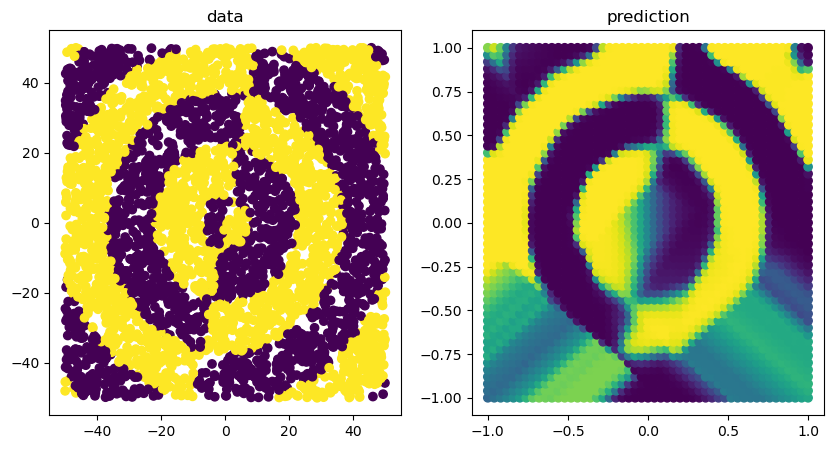

In [153]:
#Predict the possible labels of the grid created previously using the final_model_distribution 2 and plot
pred_optimized_2 = model_2.predict(grid_r)
fig, axis = plt.subplots(1, 2, figsize=(10,5))

#Raw data
axis[0].scatter(x2[:,0],x2[:,1],c=y2)
axis[0].set_title("data")

#Generated data without optimization

axis[1].scatter(grid_r[:,0],grid_r[:,1],c=pred_optimized_2)
axis[1].set_title("prediction")

The complexity has aumented Since we're dealing with a non-linear function the complexity has augmented and the result is not very accurate, nevertheless, it's a good approximation.

In [151]:
"""
#Define DNN for distribution 2 using the hyperparameters obtained at the begining 

model_2 = Sequential()
model_2.add(Dense(2,input_shape=(2,), activation='relu'))
model_2.add(Dense(90, activation='sigmoid'))
model_2.add(Dense(90, activation='sigmoid'))   
model_2.add(Dense(90, activation='sigmoid'))
model_2.add(Dropout(0.01))
model_2.add(Dense(1, activation='sigmoid'))
model_2.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model_2.summary()
"""

"\n#Define DNN for distribution 2 using the hyperparameters obtained at the begining \n\nmodel_2 = Sequential()\nmodel_2.add(Dense(2,input_shape=(2,), activation='relu'))\nmodel_2.add(Dense(90, activation='sigmoid'))\nmodel_2.add(Dense(90, activation='sigmoid'))   \nmodel_2.add(Dense(90, activation='sigmoid'))\nmodel_2.add(Dropout(0.01))\nmodel_2.add(Dense(1, activation='sigmoid'))\nmodel_2.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])\nmodel_2.summary()\n"